# Machine Learning 1 - Nearest Neighbors and Decision Trees

## Lab objectives

* Classification with decision trees and random forests.
* Cross-validation and evaluation.

In [ ]:
from lab_tools import CIFAR10

dataset = CIFAR10('../data/CIFAR10/CIFAR10/')

Pre-loading training data
Pre-loading test data


# 1. Nearest Neighbor

The following example uses the Nearest Neighbor algorithm on the Histogram of Gradient decriptors in the dataset.

In [2]:
from sklearn.neighbors import KNeighborsClassifier

kn_clf = KNeighborsClassifier(n_neighbors=1)
kn_clf.fit( dataset.train['hog'], dataset.train['labels'] )

KNeighborsClassifier(n_neighbors=1)

*Descriptive Performance of a Classifier*:
It tells you how well the classifier explains the training data. It’s about fitting: how well the model captures patterns in the data it has already seen.\
Typical metrics:
- Accuracy on the training set
- Confusion matrix on the training set
- Classification report (precision, recall, F1-score) on training data
> Example: if you train a logistic regression model, then check accuracy on the training set, you’re measuring descriptive performance.

*Predictive Performance of a Classifier*:
It measures how well the classifier generalizes to new, unseen data. It's about generalization: how good the model will be at predicting unknown examples.\
Typical metrics:
- Accuracy on the test set (or validation set)
- ROC AUC score on test data (for thresholded classifiers)
- Cross-validation scores
>Example: if you split your dataset into training and test parts, and then check how the model performs on the test set, you’re measuring predictive performance.

* What is the **descriptive performance** of this classifier ?
* Modify the code to estimate the **predictive performance**.
* Use cross-validation to find the best hyper-parameters for this method.

Train accuracy:  1.0


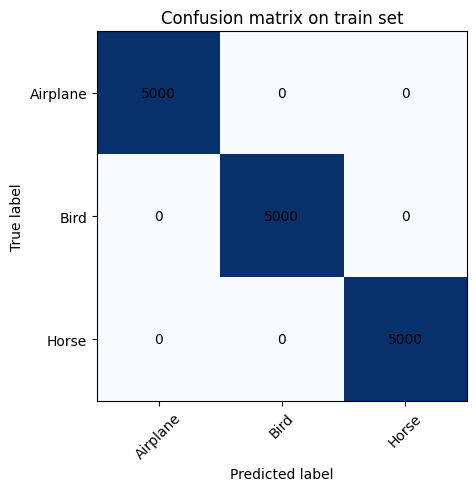

In [3]:
# descriptive performance
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score

print("Train accuracy: ", kn_clf.score( dataset.train['hog'], dataset.train['labels'] ))

#confusion matrix on train set
cm = confusion_matrix(dataset.train['labels'], kn_clf.predict(dataset.train['hog']))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix on train set')
plt.xticks(range(3), dataset.labels, rotation=45)
plt.yticks(range(3), dataset.labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Write the numbers directly into the cases
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

plt.show()


By definition of the nearest neighbour, it's descriptive performance is 100% on the training set. Because it fits the training set perfectly.

Test accuracy:  0.694
Cross-validation accuracy (only on training set):  0.6884666666666667


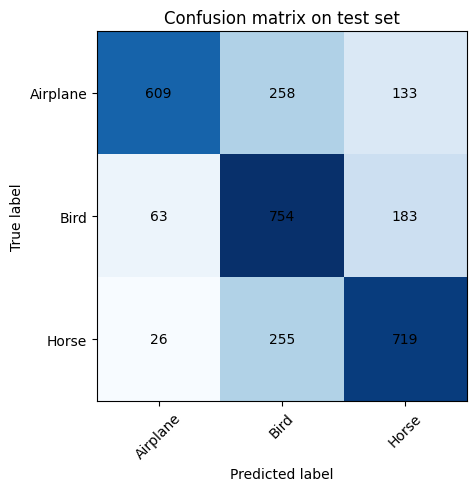

              precision    recall  f1-score   support

    Airplane       0.87      0.61      0.72      1000
        Bird       0.60      0.75      0.67      1000
       Horse       0.69      0.72      0.71      1000

    accuracy                           0.69      3000
   macro avg       0.72      0.69      0.70      3000
weighted avg       0.72      0.69      0.70      3000



In [4]:
# predictive performance
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold

print("Test accuracy: ", kn_clf.score( dataset.test['hog'], dataset.test['labels'] ))

#cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(kn_clf, dataset.train['hog'], dataset.train['labels'], cv=cv)
print("Cross-validation accuracy (only on training set): ", scores.mean())

#confusion matrix on test set
cm = confusion_matrix( dataset.test['labels'], kn_clf.predict( dataset.test['hog'] ) )
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix on test set')
plt.xticks(range(3), dataset.labels, rotation=45)
plt.yticks(range(3), dataset.labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
# Write the numbers directly into the cases
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

plt.show()

# classification report
print(classification_report( dataset.test['labels'], kn_clf.predict( dataset.test['hog'] ), target_names=dataset.labels ) )

The predictive performance is not so good, it looks like it's overfitting the training set.

In [ ]:
# Find best parameters of KNN
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
}
kn_clf = KNeighborsClassifier()
grid_search = GridSearchCV(kn_clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search.fit(dataset.train['hog'], dataset.train['labels'])
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)
# Test the best parameters on the test set
best_kn_clf = grid_search.best_estimator_
print("Test accuracy with best parameters: ", best_kn_clf.score(dataset.test['hog'], dataset.test['labels']))
#confusion matrix on test set with best parameters
cm = confusion_matrix(dataset.test['labels'], best_kn_clf.predict(dataset.test['hog']))
print(cm)

Best parameters:  {'n_neighbors': 5, 'weights': 'uniform'}
Best cross-validation score:  0.7111333333333334
Test accuracy with best parameters:  0.722
[[618 291  91]
 [ 60 811 129]
 [ 13 250 737]]


## 2. Decision Trees

[Decision Trees](http://scikit-learn.org/stable/modules/tree.html#tree) classify the data by splitting the feature space according to simple, single-feature rules. Scikit-learn uses the [CART](https://en.wikipedia.org/wiki/Predictive_analytics#Classification_and_regression_trees_.28CART.29) algorithm for [its implementation](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) of the classifier. 

* **Create a simple Decision Tree classifier** using scikit-learn and train it on the HoG training set.
* Use cross-validation to find the best hyper-parameters for this method.

Descriptive Performance Metrics
Cross-validation is done only on the training set
Accuracy from cross-validation : [0.55666667 0.57166667 0.577      0.58733333 0.56233333]
Cross-validation mean accuracy :  0.5710000000000001
Training set accuracy :  1.0
Confusion Matrix (on training set) :
 [[5000    0    0]
 [   0 5000    0]
 [   0    0 5000]]
Predictive Performance Metrics
Test set accuracy :  0.577
Confusion Matrix (on test set) :
 [[615 226 159]
 [197 524 279]
 [134 274 592]]
              precision    recall  f1-score   support

           0       0.65      0.61      0.63      1000
           1       0.51      0.52      0.52      1000
           2       0.57      0.59      0.58      1000

    accuracy                           0.58      3000
   macro avg       0.58      0.58      0.58      3000
weighted avg       0.58      0.58      0.58      3000



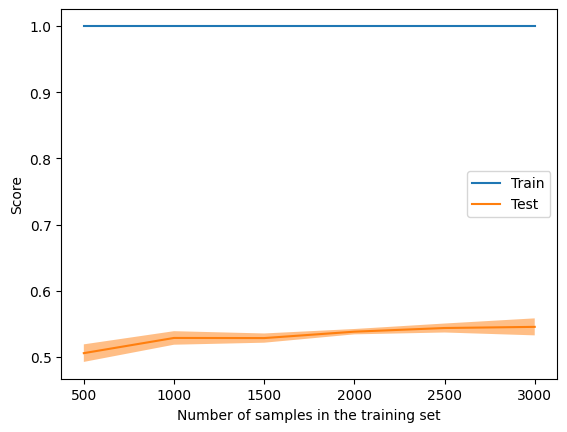

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from lab_tools import ML_pipeline

tree_clf = DecisionTreeClassifier()
ML_pipeline(tree_clf, dataset.train['hog'], dataset.train['labels'], dataset.test['hog'], dataset.test['labels'],True)

Searching best parameters...


Best parameters:  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best cross-validation score:  0.5981333333333334
Descriptive Performance Metrics
Cross-validation is done only on the training set
Accuracy from cross-validation : [0.57933333 0.59733333 0.611      0.60233333 0.60066667]
Cross-validation mean accuracy :  0.5981333333333334
Training set accuracy :  0.7938666666666667
Confusion Matrix (on training set) :
 [[4006  717  277]
 [ 399 4051  550]
 [ 238  911 3851]]
Predictive Performance Metrics
Test set accuracy :  0.6073333333333333
Confusion Matrix (on test set) :
 [[609 249 142]
 [160 625 215]
 [117 295 588]]
              precision    recall  f1-score   support

           0       0.69      0.61      0.65      1000
           1       0.53      0.62      0.58      1000
           2       0.62      0.59      0.60      1000

    accuracy                           0.61      3000
   macro avg       0.61      0.61      0.61      3000
weighted avg       0.61      

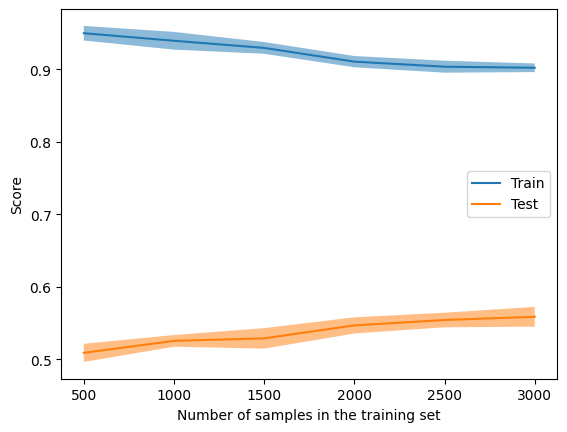

In [10]:
from lab_tools import find_best_hyperparameters
param_grid ={
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}
best_tree_model = find_best_hyperparameters(tree_clf, param_grid, dataset.train['hog'], dataset.train['labels'])
ML_pipeline(best_tree_model, dataset.train['hog'], dataset.train['labels'], dataset.test['hog'], dataset.test['labels'],True)

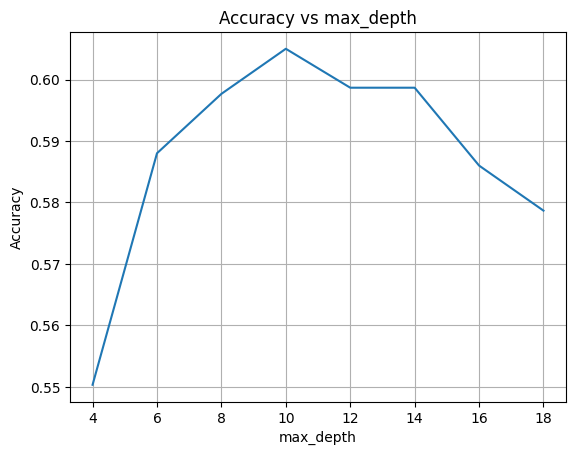

In [ ]:
#analyze in depth the evolution of the hyper-parameter max_depth
from sklearn.tree import DecisionTreeClassifier
from lab_tools import evaluate_parameter

evaluate_parameter(
    model_class=DecisionTreeClassifier,
    param_name='max_depth',
    param_range=range(4, 20, 2),
    X_train=dataset.train['hog'],
    y_train=dataset.train['labels'],
    X_test=dataset.test['hog'],
    y_test=dataset.test['labels']
)


## 3. Random Forests

[Random Forest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifiers use multiple decision trees trained on "weaker" datasets (less data and/or less features), averaging the results so as to reduce over-fitting.

* Use scikit-learn to **create a Random Forest classifier** on the CIFAR data. 
* Use cross-validation to find the best hyper-parameters for this method.

Descriptive Performance Metrics
Cross-validation is done only on the training set
Accuracy from cross-validation : [0.737      0.761      0.76666667 0.759      0.76433333]
Cross-validation mean accuracy :  0.7576
Training set accuracy :  1.0
Confusion Matrix (on training set) :
 [[5000    0    0]
 [   0 5000    0]
 [   0    0 5000]]
Predictive Performance Metrics
Test set accuracy :  0.7683333333333333
Confusion Matrix (on test set) :
 [[794 156  50]
 [124 728 148]
 [ 55 162 783]]
              precision    recall  f1-score   support

           0       0.82      0.79      0.80      1000
           1       0.70      0.73      0.71      1000
           2       0.80      0.78      0.79      1000

    accuracy                           0.77      3000
   macro avg       0.77      0.77      0.77      3000
weighted avg       0.77      0.77      0.77      3000



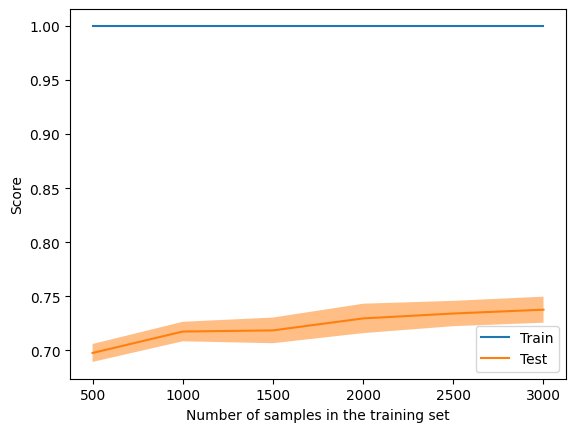

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
ML_pipeline(rf_clf, dataset.train['hog'],
            dataset.train['labels'],
            dataset.test['hog'],
            dataset.test['labels'],
            True)


Searching best parameters...
Best parameters:  {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validation score:  0.7594666666666667
Descriptive Performance Metrics
Cross-validation is done only on the training set
Accuracy from cross-validation : [0.74466667 0.76233333 0.763      0.753      0.77433333]
Cross-validation mean accuracy :  0.7594666666666667
Training set accuracy :  0.999
Confusion Matrix (on training set) :
 [[4992    8    0]
 [   4 4996    0]
 [   1    2 4997]]
Predictive Performance Metrics
Test set accuracy :  0.7556666666666667
Confusion Matrix (on test set) :
 [[775 169  56]
 [128 723 149]
 [ 55 176 769]]
              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1000
           1       0.68      0.72      0.70      1000
           2       0.79      0.77      0.78      1000

    accuracy                           0.76      3000
   macro avg       0.76      0.76      0.76      3000
weighted avg   

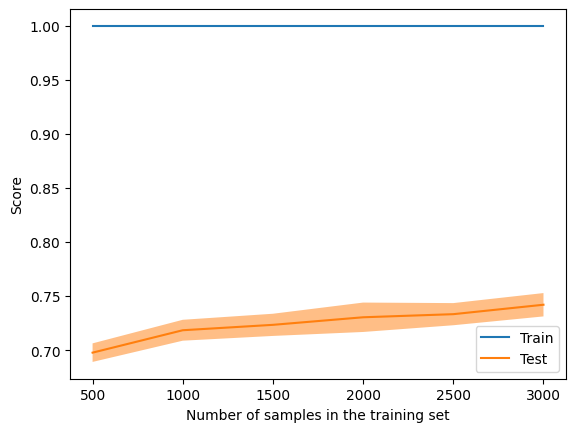

In [17]:
# find best parameters of Random Forest
from lab_tools import find_best_hyperparameters
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}
rf_clf = RandomForestClassifier(random_state=42)
best_rf_model = find_best_hyperparameters(rf_clf,
                                          param_grid,
                                          dataset.train['hog'], 
                                          dataset.train['labels'])
ML_pipeline(best_rf_model,
            dataset.train['hog'],
            dataset.train['labels'],
            dataset.test['hog'],
            dataset.test['labels'],
            True)

Searching best parameters...
Best parameters:  {'n_estimators': 130}
Best cross-validation score:  0.7511333333333333
Descriptive Performance Metrics
Cross-validation is done only on the training set
Accuracy from cross-validation : [0.73133333 0.76966667 0.75066667 0.748      0.756     ]
Cross-validation mean accuracy :  0.7511333333333333
Training set accuracy :  0.9416
Confusion Matrix (on training set) :
 [[4577  336   87]
 [ 114 4777  109]
 [  51  179 4770]]
Predictive Performance Metrics
Test set accuracy :  0.7573333333333333
Confusion Matrix (on test set) :
 [[762 182  56]
 [118 722 160]
 [ 50 162 788]]
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      1000
           1       0.68      0.72      0.70      1000
           2       0.78      0.79      0.79      1000

    accuracy                           0.76      3000
   macro avg       0.76      0.76      0.76      3000
weighted avg       0.76      0.76      0.76      3000



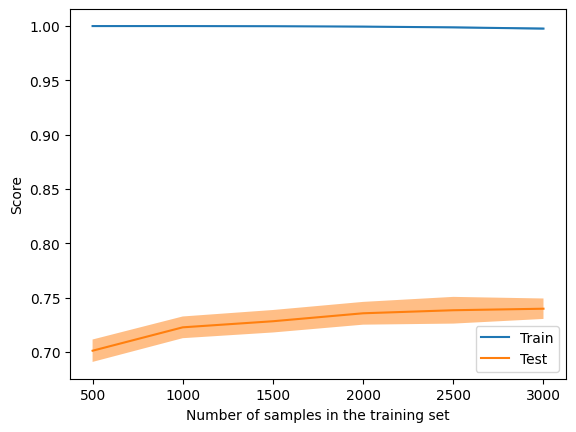

In [18]:
# extensive search of hyper-parameters (n_estimators)
rf_clf = RandomForestClassifier(random_state=42,max_depth=10)
param_grid = {
    'n_estimators': [nb_estimator for nb_estimator in range (10,150,20)],
}
best_model = find_best_hyperparameters(rf_clf, param_grid, dataset.train['hog'], dataset.train['labels'])
ML_pipeline(best_model, dataset.train['hog'], dataset.train['labels'], dataset.test['hog'], dataset.test['labels'],True)